In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

In [2]:
df = pd.read_csv('gender_classification_v7.csv')

# features
X = df.drop('gender', axis=1)
# target variable
y = df['gender']

# Graph of every feature with respect to gender

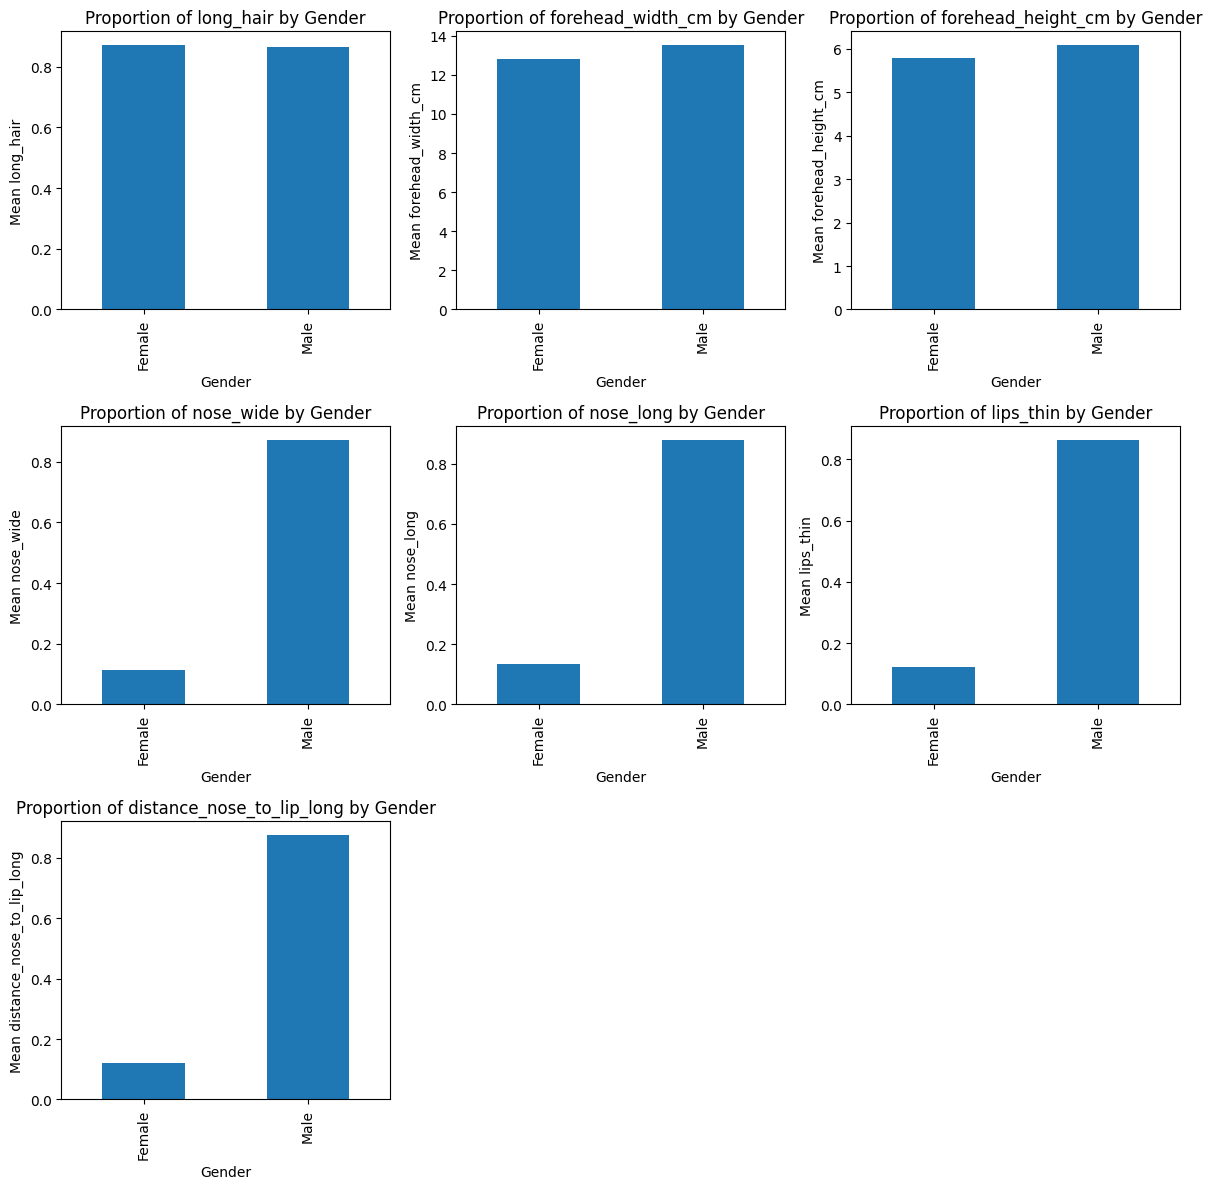

In [3]:
grouped_data = df.groupby("gender").mean()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i, attribute in enumerate(grouped_data.columns):
        ax = axes.flatten()[i]
        attribute_data = grouped_data[attribute]
        attribute_data.plot(kind="bar", ax=ax)
        ax.set_title("Proportion of {} by Gender".format(attribute))
        ax.set_xlabel("Gender")
        ax.set_ylabel("Mean {}".format(attribute))

axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()

# Show the plots
plt.show()
    

# Chi-square test

In [4]:
# chi squared
categorical = df.drop(labels = ["forehead_width_cm", "forehead_height_cm", "gender"], axis = 1)
chi2_scores, p_values = chi2(categorical, y)

for i in range(len(categorical.columns)):
    print("Feature: {} \nchi-squared score: {}\np-value: {}\n".format(categorical.columns[i], chi2_scores[i], p_values[i]))

Feature: long_hair 
chi-squared score: 0.07558300110629357
p-value: 0.7833749140143925

Feature: nose_wide 
chi-squared score: 1456.1494984509193
p-value: 0.0

Feature: nose_long 
chi-squared score: 1362.7912513734664
p-value: 2.558863188648022e-298

Feature: lips_thin 
chi-squared score: 1400.6475044528174
p-value: 1.5195849457317088e-306

Feature: distance_nose_to_lip_long 
chi-squared score: 1427.9167297718027
p-value: 0.0



The chi-square test of independence is only appropriate when both variables being tested are categorical, so it was not used on the numerical features of this data set. For those features, the Z-test for difference in proportion was deemed to be more appropriate.
With a 95% confidence level, a p-value less than or equal to 0.05 means that the feature has a statistically significant relationship to the label. The only features without a statistically significant relationship was long_hair.

# Z-Test
Only continuous features are included for this test. (forehead_width_cm, forehead_height_cm)

In [5]:
import statsmodels.stats.weightstats as ws

# continuous variables only (remove categorical features)
cont = df.drop(labels = ["long_hair", "nose_wide", "nose_long", "lips_thin", "distance_nose_to_lip_long", "gender"], axis = 1)

for feature in cont.columns:
    males = cont[y == "Male"][feature]
    females = cont[y == "Female"][feature]
    tstat, p_value = ws.ztest(males, females)
    print(f"Feature: {feature}\np-value: {p_value}\ntest statistic: {tstat}\n")

Feature: forehead_width_cm
p-value: 1.2186234014345024e-138
test statistic: 25.06432518851344

Feature: forehead_height_cm
p-value: 1.754684052276212e-92
test statistic: 20.397643970961102



With a 95% confidence level, a p-value less than or equal to 0.05 means that the feature does not differ significantly by the label. All numerical features tested were found to not differ significantly by the label.

In [6]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

# remove the insignificant features (long_hair, forehead_width_cm, forehead_height_cm)
sig_features =  df.drop(labels = ["long_hair", "forehead_width_cm", "forehead_height_cm", "gender"], axis = 1)

logit = LogisticRegression()
clf = GaussianNB()

kf = KFold(n_splits = 5)
scores = []

# Confusion matrices for linear regression (lr) and naive bayes (nb)
lr_cms = []
nb_cms = []

# Metrics arrays
# accuracies
lr_accuracies = []
nb_accuracies = []

# precision
lr_precision = []
nb_precision = []

# recalls
lr_recalls = []
nb_recalls = []


for train, test in kf.split(sig_features):
    X_train, X_test = sig_features.iloc[train], sig_features.iloc[test]
    y_train, y_test = y[train], y[test]
    

    # train
    clf.fit(X_train, y_train) # naive bayes
    logit.fit(X_train, y_train) # logistic regression
    
    # predict the labels of the test set
    y_pred_lr = logit.predict(X_test)
    y_pred_nb = clf.predict(X_test)
    
    # calculate evaluation metrics
    acc_lr = accuracy_score(y_test, y_pred_lr)
    acc_nb = accuracy_score(y_test, y_pred_nb)
    
    prec_lr = precision_score(y_test, y_pred_lr, pos_label = "Male")
    prec_nb = precision_score(y_test, y_pred_nb, pos_label = "Male")
    
    rec_lr = recall_score(y_test, y_pred_lr, pos_label = "Male")
    rec_nb = recall_score(y_test, y_pred_nb, pos_label = "Male")
    
    lr_accuracies.append(acc_lr)
    nb_accuracies.append(acc_nb)

    lr_precision.append(prec_lr)
    nb_precision.append(prec_nb)

    lr_recalls.append(rec_lr)
    nb_recalls.append(rec_nb)
    
    
    # create the confusion matrices
    lr_cm = confusion_matrix(y_test, y_pred_lr)
    nb_cm = confusion_matrix(y_test, y_pred_nb)
    
    # add it to the list of confusion matrices
    lr_cms.append(pd.DataFrame(lr_cm, index=['Actual Female', 'Actual Male'], columns=['Predicted Female', 'Predicted Male']))
    nb_cms.append(pd.DataFrame(nb_cm, index=['Actual Female', 'Actual Male'], columns=['Predicted Female', 'Predicted Male']))

# print the confusion matrices
for i, (cm1, cm2) in enumerate(zip(lr_cms, nb_cms)):
    print("Test Set #", i+1)
    print("================================================")
    print("Logistic Regression:\n", cm1, "\n")
    print("Accuracy:\t{:.2f}%".format(lr_accuracies[i] * 100))
    print("Precision:\t{:.2f}%".format(lr_precision[i] * 100))
    print("Recall:\t\t{:.2f}%".format(lr_recalls[i] * 100))
    print("------------------------------------------------")
    print("Naive Bayes:\n", cm2, "\n")
    print("Accuracy:\t{:.2f}%".format(nb_accuracies[i] * 100))
    print("Precision:\t{:.2f}%".format(nb_precision[i] * 100))
    print("Recall:\t\t{:.2f}%".format(nb_recalls[i] * 100))
    print("================================================\n\n")
    

print("Final Results:")
print("Logistic Regression:")
print("Mean Accuracy:\t{:.2f}%".format(np.average(lr_accuracies) * 100))
print("Mean Precision:\t{:.2f}%".format(np.average(lr_precision) * 100))
print("Mean Recall:\t{:.2f}%\n".format(np.average(lr_recalls) * 100))
print("Naive Bayes:")
print("Mean Accuracy:\t{:.2f}%".format(np.average(nb_accuracies) * 100))
print("Mean Precision:\t{:.2f}%".format(np.average(nb_precision) * 100))
print("Mean Recall:\t{:.2f}%".format(np.average(nb_recalls) * 100))


Test Set # 1
Logistic Regression:
                Predicted Female  Predicted Male
Actual Female               473              22
Actual Male                  27             479 

Accuracy:	95.10%
Precision:	95.61%
Recall:		94.66%
------------------------------------------------
Naive Bayes:
                Predicted Female  Predicted Male
Actual Female               460              35
Actual Male                  10             496 

Accuracy:	95.50%
Precision:	93.41%
Recall:		98.02%


Test Set # 2
Logistic Regression:
                Predicted Female  Predicted Male
Actual Female               467              18
Actual Male                  27             488 

Accuracy:	95.50%
Precision:	96.44%
Recall:		94.76%
------------------------------------------------
Naive Bayes:
                Predicted Female  Predicted Male
Actual Female               460              25
Actual Male                  21             494 

Accuracy:	95.40%
Precision:	95.18%
Recall:		95.92%


Test Set # 3

Above are the results of each of the 5 subtests of the k- foldcross validation